# Giesekus Creep: Strain Response Under Constant Stress

## Protocol Overview: Creep and Creep Compliance

In a creep test, we apply a constant stress σ₀ at t = 0 and measure the strain γ(t) over time. The **creep compliance** J(t) = γ(t)/σ₀ characterizes the material's time-dependent deformability.

**Key physics for Giesekus:**  
For a Maxwell fluid (linear viscoelastic):
$$
J(t) = \frac{1}{G}\left(1 + \frac{t}{\lambda}\right) = J_0 + \frac{t}{\eta_0}
$$

For the Giesekus model, the creep response is **nonlinear** due to the α·τ·τ term:
- **Low stress** (σ₀ ≪ G): Response approaches linear Maxwell
- **High stress** (σ₀ ~ G): Nonlinearity accelerates creep via anisotropic drag

The strain response is computed by solving the tensorial ODE with constant shear stress τ_xy = σ₀ (stress-controlled closure).

**Time scales:**
- **t ≪ λ**: Elastic response, γ ≈ σ₀/G (instantaneous compliance J₀ = 1/G)
- **t ≫ λ**: Viscous flow, γ ≈ σ₀·t/η₀ (steady-state slope dJ/dt = 1/η₀)

## Learning Objectives

1. Fit the Giesekus model to real mucus creep compliance data
2. Understand creep behavior in viscoelastic fluids (elastic → viscoelastic → viscous)
3. Extract retardation spectrum from creep response
4. Compare Giesekus creep to Maxwell (single exponential)
5. Use ODE-based simulation via diffrax for stress-controlled protocols

## Prerequisites

- Basic RheoJAX usage (basic/01-maxwell-fitting.ipynb)
- Bayesian inference fundamentals (bayesian/01-bayesian-basics.ipynb)

## Estimated Runtime

- **Fast demo** (NUM_CHAINS=1, NUM_SAMPLES=500): ~3-5 minutes
- **Full run** (NUM_CHAINS=4, NUM_SAMPLES=2000): ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import gc
import json
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.giesekus import GiesekusSingleMode

# Add examples root to path for shared utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# Suppress equinox DeprecationWarning (jax.core.mapped_aval/unmapped_aval deprecated in JAX 0.8+)
warnings.filterwarnings("ignore", message=".*jax\\.core\\.(mapped|unmapped)_aval.*", category=DeprecationWarning)

# CI/demo toggle: True = fast (fewer samples), False = production (full inference)
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


## 2. Theory: Creep in Viscoelastic Fluids

### The Experiment

In a creep test, we apply a constant stress σ₀ at t = 0 and measure the strain γ(t) over time.

### Creep Compliance

The creep compliance is defined as:
$$
J(t) = \frac{\gamma(t)}{\sigma_0}
$$

For a Maxwell fluid (linear viscoelastic):
$$
J(t) = \frac{1}{G} + \frac{t}{\eta} = \frac{1}{G}\left(1 + \frac{t}{\lambda}\right)
$$

where G = η/λ is the elastic modulus.

### Giesekus Creep

For the Giesekus model, the creep response is **nonlinear** due to the τ·τ term. At low stresses (σ₀ << G), the response approaches Maxwell. At high stresses, the nonlinearity accelerates creep.

The strain response is computed by solving the tensorial ODE:
$$
\boldsymbol{\tau} + \lambda \stackrel{\nabla}{\boldsymbol{\tau}} + \frac{\alpha \lambda}{\eta_p} \boldsymbol{\tau} \cdot \boldsymbol{\tau} = 2\eta_p \mathbf{D}
$$

subject to constant shear stress τ_xy = σ₀.

### Key Features

| Time Scale | Behavior |
|------------|----------|
| t << λ | Elastic response: γ ≈ σ₀/G |
| t >> λ | Viscous flow: γ ≈ σ₀·t/η |
| t ~ λ | Transition: viscoelastic creep |

## 3. Load Data

We use mucus creep compliance data. Mucus is a biopolymer gel that exhibits complex viscoelastic behavior.

In [3]:
# Load mucus creep data
data_path = os.path.join("..", "data", "creep", "biological", "creep_mucus_data.csv")

# Tab-separated with header
raw = np.loadtxt(data_path, delimiter="\t", skiprows=1)
time_data = raw[:, 0]  # Time (s)
J_data = raw[:, 1]  # Creep compliance (1/Pa)

print(f"Loaded {len(time_data)} data points")
print(f"Time range: [{time_data.min():.2f}, {time_data.max():.1f}] s")
print(f"J range: [{J_data.min():.2e}, {J_data.max():.2e}] 1/Pa")

Loaded 20 data points
Time range: [0.50, 10.0] s
J range: [9.84e-01, 2.37e+00] 1/Pa


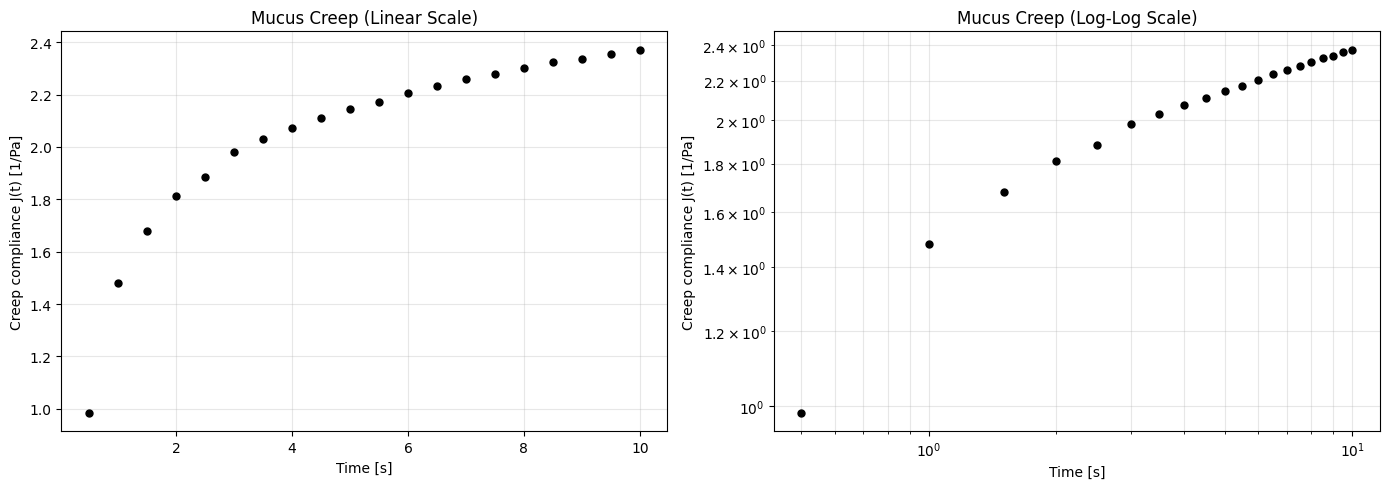

In [4]:
# Plot raw data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
ax1.plot(time_data, J_data, "ko", markersize=5)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Creep compliance J(t) [1/Pa]")
ax1.set_title("Mucus Creep (Linear Scale)")
ax1.grid(True, alpha=0.3)

# Log-log scale
ax2.loglog(time_data, J_data, "ko", markersize=5)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Creep compliance J(t) [1/Pa]")
ax2.set_title("Mucus Creep (Log-Log Scale)")
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

We fit the Giesekus model to the creep compliance data.

In [5]:
# Create and fit Giesekus model
model = GiesekusSingleMode()

# For creep, we need to specify the applied stress
# Assume σ = 1 Pa for compliance normalization (J = γ/σ)
sigma_applied = 1.0  # Pa

# Estimate initial parameters from data to ensure stable fitting
# G ~ 1/J(0), η ~ 1/slope(J) at long times, λ ~ η/G
G_est = 1.0 / J_data[0]
idx_late = len(time_data) // 2
slope = np.polyfit(time_data[idx_late:], J_data[idx_late:], 1)[0]
eta_est = 1.0 / max(slope, 1e-10)
lambda_est = eta_est / max(G_est, 1e-10)

# Set initial parameters
# CRITICAL: eta_s must be non-zero for creep ODE stability
model.parameters.set_value('eta_p', max(eta_est, 1.0))
model.parameters.set_value('lambda_1', max(lambda_est, 0.1))
model.parameters.set_value('alpha', 0.1)
model.parameters.set_value('eta_s', max(0.1, 0.01 * eta_est))  # Small but non-zero

print("Initial parameter estimates from data:")
print(f"  G_est = {G_est:.4g} Pa, η_est = {eta_est:.4g} Pa·s, λ_est = {lambda_est:.4g} s")

t0 = time.time()
model.fit(time_data, J_data, test_mode="creep", sigma_applied=sigma_applied, method='scipy')
t_nlsq = time.time() - t0

print(f"\nNLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
param_names = ["eta_p", "lambda_1", "alpha", "eta_s"]
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:10s} = {val:.4g}")

# Derived quantities
eta_p = model.parameters.get_value("eta_p")
eta_s = model.parameters.get_value("eta_s")
lambda_1 = model.parameters.get_value("lambda_1")
alpha = model.parameters.get_value("alpha")

eta_0 = eta_p + eta_s
G_0 = eta_p / lambda_1

print(f"\nDerived quantities:")
print(f"  η₀ = η_p + η_s = {eta_0:.2f} Pa·s")
print(f"  G₀ = η_p/λ = {G_0:.2f} Pa")
print(f"  J₀ = 1/G₀ = {1/G_0:.4e} 1/Pa")

Initial parameter estimates from data:
  G_est = 1.016 Pa, η_est = 23.11 Pa·s, λ_est = 22.73 s



NLSQ fit time: 47.33 s

Fitted parameters:
  eta_p      = 14.32
  lambda_1   = 26.21
  alpha      = 5.723e-10
  eta_s      = 0.1779

Derived quantities:
  η₀ = η_p + η_s = 14.50 Pa·s
  G₀ = η_p/λ = 0.55 Pa
  J₀ = 1/G₀ = 1.8304e+00 1/Pa


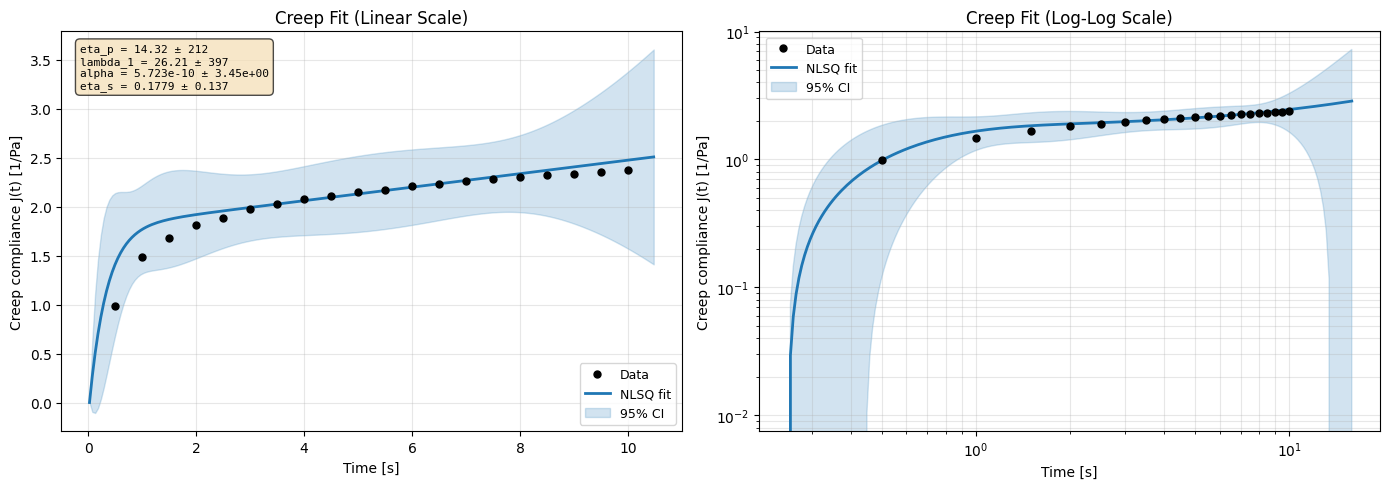

In [6]:
# Plot NLSQ fit with uncertainty band
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
plot_nlsq_fit(
    time_data, J_data, model, test_mode="creep",
    param_names=param_names,
    log_scale=False,
    xlabel="Time [s]", ylabel="Creep compliance J(t) [1/Pa]",
    title="Creep Fit (Linear Scale)",
    ax=ax1,
    sigma_applied=sigma_applied,
)

# Log-log scale
plot_nlsq_fit(
    time_data, J_data, model, test_mode="creep",
    param_names=param_names,
    log_scale=True,
    xlabel="Time [s]", ylabel="Creep compliance J(t) [1/Pa]",
    title="Creep Fit (Log-Log Scale)",
    show_annotation=False,
    ax=ax2,
    sigma_applied=sigma_applied,
)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference

In [7]:
# Bayesian inference with NLSQ warm-start
initial_values = {
    name: model.parameters.get_value(name)
    for name in param_names
}
print("Warm-start values:")
for k, v in initial_values.items():
    print(f"  {k}: {v:.4g}")

# FAST_MODE: quick CI validation; production: full inference
if FAST_MODE:
    NUM_WARMUP = 50
    NUM_SAMPLES = 100
    NUM_CHAINS = 1
else:
    NUM_WARMUP = 1000
    NUM_SAMPLES = 2000
    NUM_CHAINS = 4

gc.collect()

t0 = time.time()
result = model.fit_bayesian(
    time_data,
    J_data,
    test_mode="creep",
    sigma_applied=sigma_applied,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
    target_accept_prob=0.95,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values:
  eta_p: 14.32
  lambda_1: 26.21
  alpha: 5.723e-10
  eta_s: 0.1779


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:10<25:19, 10.20s/it, 1 steps of size 1.78e+00. acc. prob=0.00]

warmup:   1%|▏         | 2/150 [00:12<13:05,  5.30s/it, 1 steps of size 1.14e-01. acc. prob=0.00]

warmup:   2%|▏         | 3/150 [00:14<10:06,  4.12s/it, 1 steps of size 5.03e-03. acc. prob=0.00]

warmup:   3%|▎         | 4/150 [00:17<08:21,  3.44s/it, 1 steps of size 1.93e-04. acc. prob=0.00]

warmup:   3%|▎         | 5/150 [00:19<07:42,  3.19s/it, 1 steps of size 7.07e-06. acc. prob=0.00]

warmup:   7%|▋         | 10/150 [00:20<02:07,  1.09it/s, 255 steps of size 5.02e-10. acc. prob=0.20]

warmup:   8%|▊         | 12/150 [00:20<01:37,  1.42it/s, 255 steps of size 7.58e-10. acc. prob=0.33]

warmup:   9%|▉         | 14/150 [00:20<01:16,  1.78it/s, 255 steps of size 1.30e-09. acc. prob=0.43]

warmup:  10%|█         | 15/150 [00:21<01:05,  2.05it/s, 255 steps of size 1.76e-09. acc. prob=0.47]

warmup:  11%|█         | 16/150 [00:21<00:57,  2.34it/s, 255 steps of size 2.40e-09. acc. prob=0.50]

warmup:  11%|█▏        | 17/150 [00:21<00:47,  2.81it/s, 255 steps of size 3.29e-09. acc. prob=0.53]

warmup:  12%|█▏        | 18/150 [00:21<00:40,  3.27it/s, 255 steps of size 4.53e-09. acc. prob=0.56]

warmup:  13%|█▎        | 19/150 [00:21<00:34,  3.81it/s, 255 steps of size 6.26e-09. acc. prob=0.58]

warmup:  13%|█▎        | 20/150 [00:21<00:29,  4.34it/s, 255 steps of size 8.65e-09. acc. prob=0.60]

warmup:  14%|█▍        | 21/150 [00:21<00:26,  4.82it/s, 255 steps of size 1.19e-08. acc. prob=0.62]

warmup:  15%|█▍        | 22/150 [00:22<00:23,  5.44it/s, 255 steps of size 1.64e-08. acc. prob=0.64]

warmup:  15%|█▌        | 23/150 [00:22<00:21,  5.93it/s, 255 steps of size 2.26e-08. acc. prob=0.65]

warmup:  16%|█▌        | 24/150 [00:22<00:21,  5.84it/s, 255 steps of size 3.09e-08. acc. prob=0.67]

warmup:  17%|█▋        | 25/150 [00:22<00:20,  6.12it/s, 255 steps of size 4.22e-08. acc. prob=0.68]

warmup:  17%|█▋        | 26/150 [00:22<00:20,  6.19it/s, 255 steps of size 5.73e-08. acc. prob=0.69]

warmup:  18%|█▊        | 27/150 [00:22<00:19,  6.26it/s, 255 steps of size 7.74e-08. acc. prob=0.70]

warmup:  19%|█▊        | 28/150 [00:22<00:18,  6.45it/s, 255 steps of size 1.04e-07. acc. prob=0.71]

warmup:  19%|█▉        | 29/150 [00:23<00:21,  5.63it/s, 255 steps of size 1.40e-07. acc. prob=0.72]

warmup:  20%|██        | 30/150 [00:23<00:19,  6.31it/s, 255 steps of size 1.86e-07. acc. prob=0.73]

warmup:  21%|██        | 31/150 [00:23<00:17,  6.80it/s, 255 steps of size 2.47e-07. acc. prob=0.74]

warmup:  21%|██▏       | 32/150 [00:23<00:16,  7.36it/s, 255 steps of size 3.26e-07. acc. prob=0.75]

warmup:  22%|██▏       | 33/150 [00:23<00:14,  7.81it/s, 255 steps of size 4.29e-07. acc. prob=0.76]

warmup:  23%|██▎       | 34/150 [00:23<00:18,  6.22it/s, 255 steps of size 5.61e-07. acc. prob=0.76]

warmup:  23%|██▎       | 35/150 [00:23<00:16,  6.87it/s, 255 steps of size 7.30e-07. acc. prob=0.77]

warmup:  24%|██▍       | 36/150 [00:24<00:16,  6.98it/s, 255 steps of size 9.47e-07. acc. prob=0.78]

warmup:  25%|██▍       | 37/150 [00:24<00:16,  6.88it/s, 255 steps of size 1.22e-06. acc. prob=0.78]

warmup:  25%|██▌       | 38/150 [00:24<00:17,  6.48it/s, 255 steps of size 1.57e-06. acc. prob=0.79]

warmup:  26%|██▌       | 39/150 [00:24<00:17,  6.21it/s, 255 steps of size 2.01e-06. acc. prob=0.79]

warmup:  27%|██▋       | 40/150 [00:24<00:18,  6.00it/s, 255 steps of size 2.56e-06. acc. prob=0.80]

warmup:  27%|██▋       | 41/150 [00:24<00:17,  6.37it/s, 255 steps of size 3.25e-06. acc. prob=0.80]

warmup:  28%|██▊       | 42/150 [00:25<00:15,  6.80it/s, 255 steps of size 4.11e-06. acc. prob=0.81]

warmup:  29%|██▊       | 43/150 [00:25<00:20,  5.27it/s, 255 steps of size 5.17e-06. acc. prob=0.81]

warmup:  29%|██▉       | 44/150 [00:25<00:17,  5.97it/s, 255 steps of size 6.49e-06. acc. prob=0.82]

warmup:  30%|███       | 45/150 [00:25<00:17,  5.94it/s, 255 steps of size 8.11e-06. acc. prob=0.82]

warmup:  31%|███       | 46/150 [00:25<00:17,  5.86it/s, 255 steps of size 8.88e-05. acc. prob=0.83]

warmup:  31%|███▏      | 47/150 [00:25<00:15,  6.45it/s, 255 steps of size 1.03e-04. acc. prob=0.83]

warmup:  32%|███▏      | 48/150 [00:26<00:14,  6.86it/s, 255 steps of size 1.21e-04. acc. prob=0.83]

warmup:  33%|███▎      | 49/150 [00:26<00:14,  7.13it/s, 255 steps of size 1.44e-04. acc. prob=0.84]

sample:  34%|███▍      | 51/150 [00:26<00:12,  8.02it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  35%|███▍      | 52/150 [00:26<00:12,  7.88it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  35%|███▌      | 53/150 [00:26<00:12,  8.01it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  36%|███▌      | 54/150 [00:27<00:18,  5.25it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  37%|███▋      | 55/150 [00:27<00:16,  5.63it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  37%|███▋      | 56/150 [00:27<00:16,  5.84it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  38%|███▊      | 57/150 [00:27<00:15,  5.88it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  39%|███▊      | 58/150 [00:27<00:15,  5.94it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  39%|███▉      | 59/150 [00:27<00:19,  4.73it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  41%|████      | 61/150 [00:28<00:14,  6.11it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  41%|████▏     | 62/150 [00:28<00:15,  5.61it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  42%|████▏     | 63/150 [00:28<00:17,  5.06it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  43%|████▎     | 64/150 [00:28<00:15,  5.64it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  43%|████▎     | 65/150 [00:28<00:13,  6.42it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  44%|████▍     | 66/150 [00:29<00:12,  6.62it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  45%|████▍     | 67/150 [00:29<00:15,  5.36it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  45%|████▌     | 68/150 [00:29<00:13,  5.98it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  46%|████▌     | 69/150 [00:29<00:12,  6.71it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  47%|████▋     | 70/150 [00:29<00:10,  7.34it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  47%|████▋     | 71/150 [00:29<00:12,  6.45it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  48%|████▊     | 72/150 [00:29<00:12,  6.49it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  49%|████▊     | 73/150 [00:30<00:11,  6.45it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  49%|████▉     | 74/150 [00:30<00:12,  6.03it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  50%|█████     | 75/150 [00:30<00:14,  5.27it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  51%|█████     | 76/150 [00:30<00:12,  5.89it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  51%|█████▏    | 77/150 [00:30<00:11,  6.35it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  52%|█████▏    | 78/150 [00:30<00:10,  6.83it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  53%|█████▎    | 79/150 [00:31<00:10,  7.04it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  53%|█████▎    | 80/150 [00:31<00:10,  6.87it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  54%|█████▍    | 81/150 [00:31<00:09,  7.53it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  55%|█████▍    | 82/150 [00:31<00:09,  7.26it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  55%|█████▌    | 83/150 [00:31<00:08,  7.56it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  56%|█████▌    | 84/150 [00:31<00:09,  7.28it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  57%|█████▋    | 85/150 [00:31<00:08,  7.73it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  57%|█████▋    | 86/150 [00:31<00:07,  8.07it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  58%|█████▊    | 87/150 [00:32<00:07,  8.37it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  59%|█████▊    | 88/150 [00:32<00:07,  8.39it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  59%|█████▉    | 89/150 [00:32<00:07,  8.57it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  60%|██████    | 90/150 [00:32<00:10,  5.81it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  61%|██████    | 91/150 [00:32<00:12,  4.83it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  61%|██████▏   | 92/150 [00:33<00:11,  5.27it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  62%|██████▏   | 93/150 [00:33<00:12,  4.61it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  63%|██████▎   | 94/150 [00:33<00:11,  4.94it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  63%|██████▎   | 95/150 [00:33<00:11,  4.80it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  64%|██████▍   | 96/150 [00:33<00:09,  5.62it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  65%|██████▍   | 97/150 [00:33<00:08,  5.90it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  65%|██████▌   | 98/150 [00:34<00:09,  5.69it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  66%|██████▌   | 99/150 [00:34<00:08,  6.30it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  67%|██████▋   | 100/150 [00:34<00:07,  6.98it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  67%|██████▋   | 101/150 [00:34<00:06,  7.46it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  68%|██████▊   | 102/150 [00:34<00:06,  7.45it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  69%|██████▊   | 103/150 [00:34<00:07,  6.37it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  69%|██████▉   | 104/150 [00:35<00:07,  6.13it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  70%|███████   | 105/150 [00:35<00:07,  5.89it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  71%|███████   | 106/150 [00:35<00:06,  6.42it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  71%|███████▏  | 107/150 [00:35<00:07,  5.72it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  72%|███████▏  | 108/150 [00:35<00:06,  6.35it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  73%|███████▎  | 109/150 [00:35<00:06,  6.39it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  73%|███████▎  | 110/150 [00:35<00:05,  6.90it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  74%|███████▍  | 111/150 [00:36<00:05,  6.88it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  75%|███████▍  | 112/150 [00:36<00:05,  6.65it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  75%|███████▌  | 113/150 [00:36<00:05,  6.40it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  76%|███████▌  | 114/150 [00:36<00:05,  6.75it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  77%|███████▋  | 115/150 [00:36<00:05,  6.82it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  78%|███████▊  | 117/150 [00:36<00:04,  7.50it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  79%|███████▊  | 118/150 [00:37<00:04,  7.81it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  79%|███████▉  | 119/150 [00:37<00:03,  8.04it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  80%|████████  | 120/150 [00:37<00:03,  8.43it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  81%|████████  | 121/150 [00:37<00:03,  8.22it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  81%|████████▏ | 122/150 [00:37<00:03,  7.58it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  82%|████████▏ | 123/150 [00:37<00:03,  7.75it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  83%|████████▎ | 124/150 [00:37<00:03,  7.06it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  83%|████████▎ | 125/150 [00:37<00:03,  7.16it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  84%|████████▍ | 126/150 [00:38<00:03,  7.08it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  85%|████████▍ | 127/150 [00:38<00:03,  7.59it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  85%|████████▌ | 128/150 [00:38<00:02,  7.98it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  86%|████████▌ | 129/150 [00:38<00:02,  8.03it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  87%|████████▋ | 130/150 [00:38<00:02,  7.74it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  87%|████████▋ | 131/150 [00:38<00:02,  7.29it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  88%|████████▊ | 132/150 [00:38<00:02,  7.79it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  89%|████████▊ | 133/150 [00:38<00:02,  7.77it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  89%|████████▉ | 134/150 [00:39<00:02,  7.99it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  90%|█████████ | 135/150 [00:39<00:01,  8.38it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  91%|█████████ | 136/150 [00:39<00:01,  8.16it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  91%|█████████▏| 137/150 [00:39<00:01,  7.81it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  92%|█████████▏| 138/150 [00:39<00:01,  7.53it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  93%|█████████▎| 139/150 [00:39<00:01,  6.87it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  93%|█████████▎| 140/150 [00:39<00:01,  7.32it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  94%|█████████▍| 141/150 [00:40<00:01,  7.49it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  95%|█████████▍| 142/150 [00:40<00:01,  6.64it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  95%|█████████▌| 143/150 [00:40<00:01,  6.31it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  96%|█████████▌| 144/150 [00:40<00:00,  6.93it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  97%|█████████▋| 145/150 [00:40<00:00,  6.85it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  97%|█████████▋| 146/150 [00:40<00:00,  7.36it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  98%|█████████▊| 147/150 [00:40<00:00,  6.80it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample:  99%|█████████▉| 149/150 [00:41<00:00,  7.80it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample: 100%|██████████| 150/150 [00:41<00:00,  8.23it/s, 255 steps of size 1.32e-04. acc. prob=1.00]

sample: 100%|██████████| 150/150 [00:41<00:00,  3.63it/s, 255 steps of size 1.32e-04. acc. prob=1.00]


Bayesian inference time: 54.8 s


In [8]:
# Convergence diagnostics
diag = result.diagnostics

print("Convergence Diagnostics")
print("=" * 55)
print(f"{'Parameter':>12s}  {'R-hat':>8s}  {'ESS':>8s}  {'Status':>8s}")
print("-" * 55)

for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    status = "PASS" if (r_hat < 1.05 and ess > 100) else "CHECK"
    print(f"{p:>12s}  {r_hat:8.4f}  {ess:8.0f}  {status:>8s}")

n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")

Convergence Diagnostics
   Parameter     R-hat       ESS    Status
-------------------------------------------------------
       eta_p    1.0322        17     CHECK
    lambda_1    1.0739         7     CHECK
       alpha    1.1546         6     CHECK
       eta_s    1.2058         7     CHECK

Divergences: 0


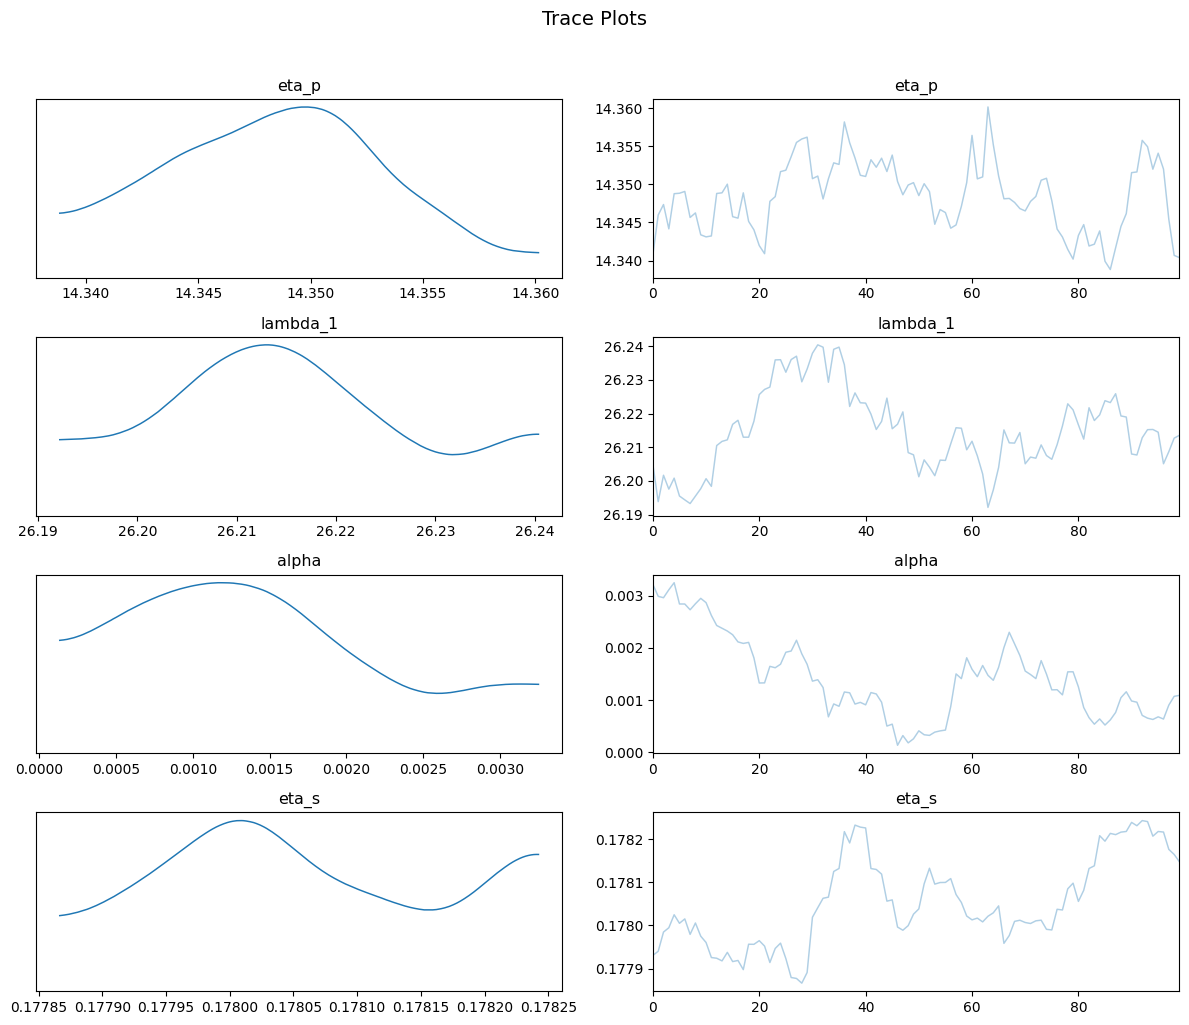

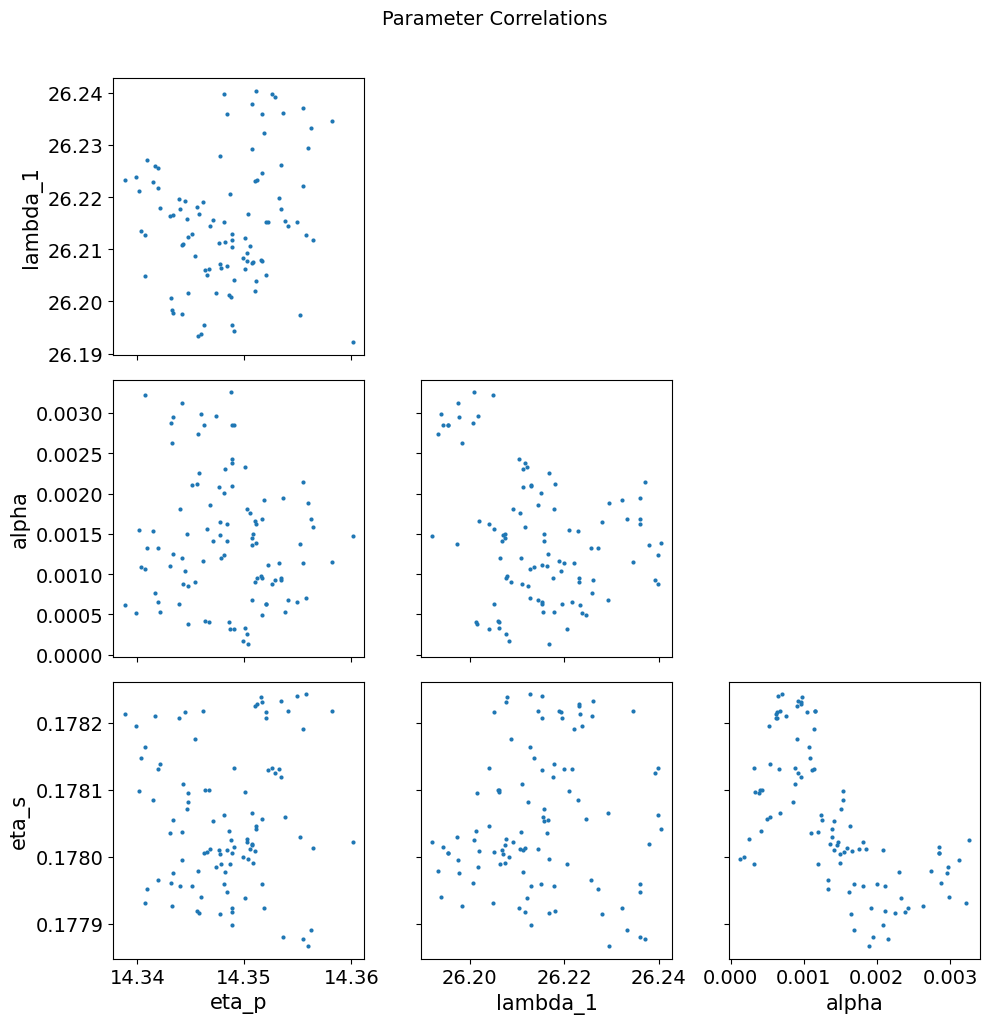

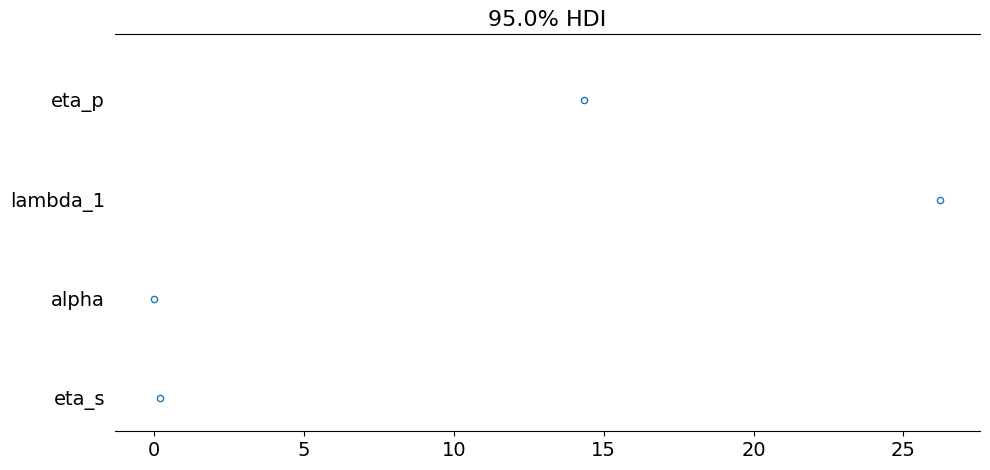

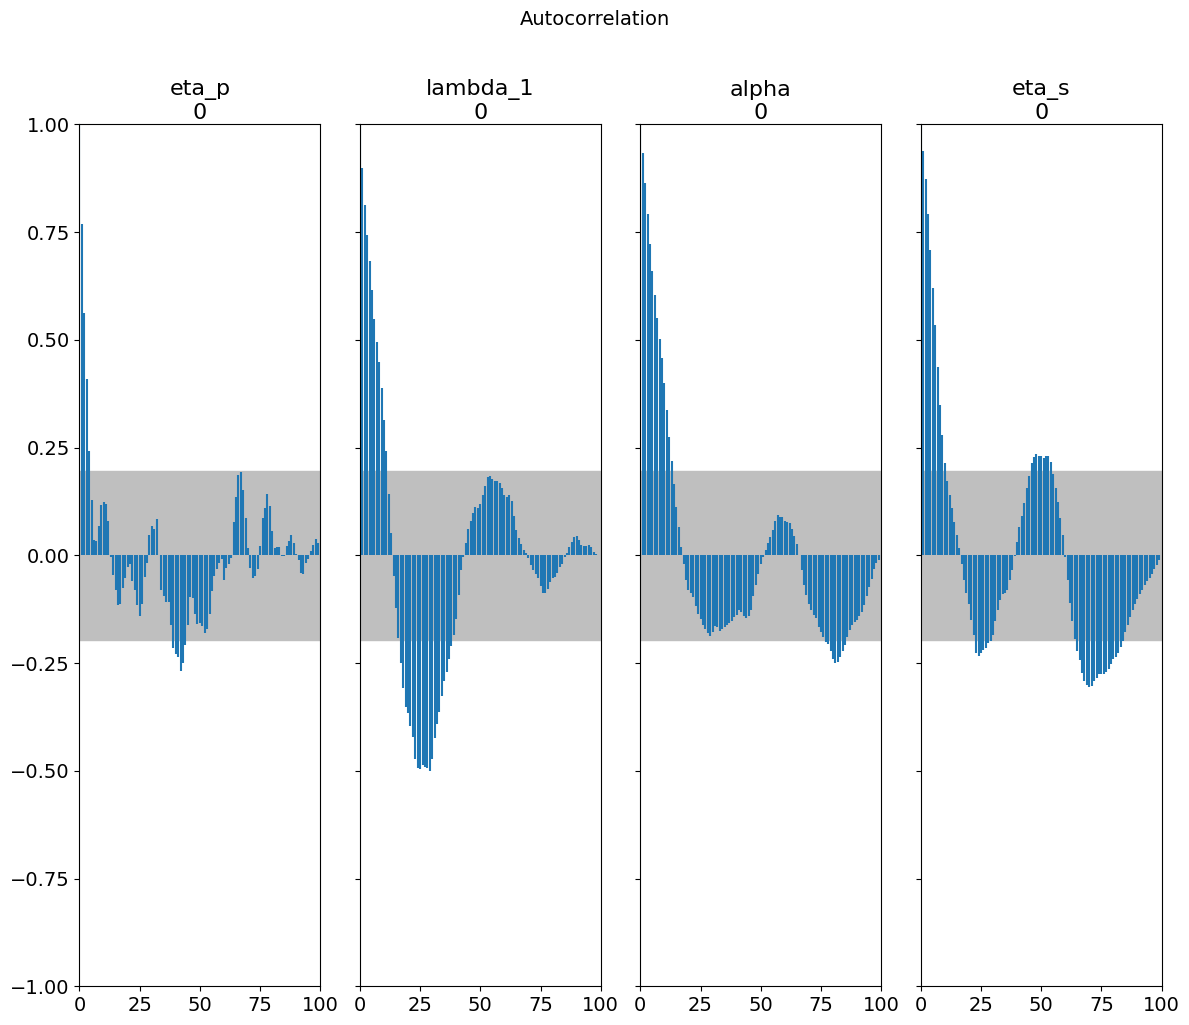

In [9]:
# Full ArviZ diagnostics: trace, pair, forest, energy, autocorr, rank
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

## 6. Posterior Predictive Check

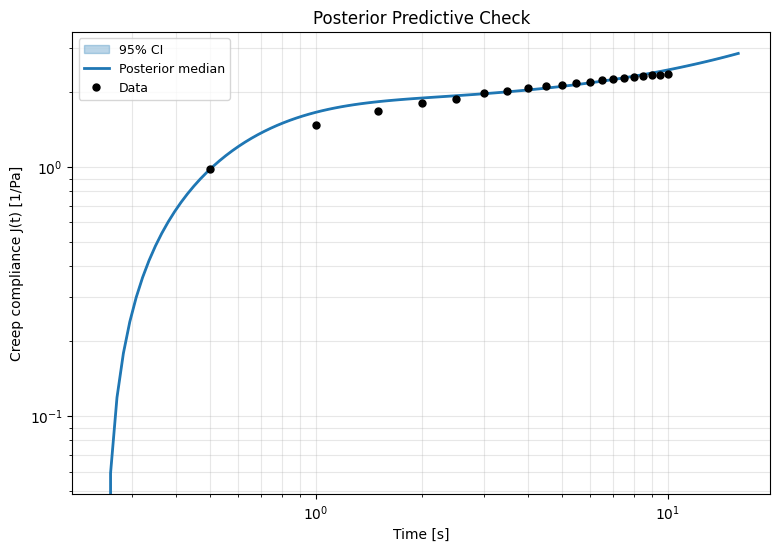

In [10]:
# Posterior predictive with 95% credible intervals
posterior = result.posterior_samples

fig, ax = plot_posterior_predictive(
    time_data, J_data, model, result,
    test_mode="creep", param_names=param_names,
    n_draws=min(100, len(posterior[param_names[0]])),
    log_scale=True,
    xlabel="Time [s]", ylabel="Creep compliance J(t) [1/Pa]",
    title="Posterior Predictive Check",
    sigma_applied=sigma_applied,
)
display(fig)
plt.close(fig)

## 7. Parameter Summary

In [11]:
# NLSQ vs Bayesian comparison
print("Parameter Comparison: NLSQ vs Bayesian")
print("=" * 70)
print(f"{'Param':>12s}  {'NLSQ':>12s}  {'Bayes median':>14s}  {'95% CI':>26s}")
print("-" * 70)

# Reset NLSQ values first
for name, val in initial_values.items():
    model.parameters.set_value(name, val)

for name in param_names:
    nlsq_val = initial_values[name]
    bayes_samples = posterior[name]
    median = float(np.median(bayes_samples))
    lo = float(np.percentile(bayes_samples, 2.5))
    hi = float(np.percentile(bayes_samples, 97.5))
    print(f"{name:>12s}  {nlsq_val:12.4g}  {median:14.4g}  [{lo:.4g}, {hi:.4g}]")

Parameter Comparison: NLSQ vs Bayesian
       Param          NLSQ    Bayes median                      95% CI
----------------------------------------------------------------------
       eta_p         14.32           14.35  [14.34, 14.36]
    lambda_1         26.21           26.21  [26.19, 26.24]
       alpha     5.723e-10        0.001346  [0.0002845, 0.003058]
       eta_s        0.1779           0.178  [0.1779, 0.1782]


## 8. Save Results

In [12]:
# Save results
output_dir = os.path.join("..", "outputs", "giesekus", "creep")
os.makedirs(output_dir, exist_ok=True)

# Save NLSQ point estimates
nlsq_params = initial_values.copy()
with open(os.path.join(output_dir, "nlsq_params_creep.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

# Save posterior samples
posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
with open(os.path.join(output_dir, "posterior_creep.json"), "w") as f:
    json.dump(posterior_dict, f)

print(f"Results saved to {output_dir}/")

Results saved to ../outputs/giesekus/creep/


## Key Takeaways

1. **Creep compliance** J(t) = γ(t)/σ₀ characterizes the strain response under constant stress. It reveals the transition from elastic (t ≪ λ) to viscous (t ≫ λ) behavior.

2. **Short-time behavior** (t ≪ λ) is elastic: γ ≈ σ₀/G, giving instantaneous compliance J₀ = 1/G = λ/η_p.

3. **Long-time behavior** (t ≫ λ) is viscous: γ ≈ σ₀·t/η₀, giving steady-state slope dJ/dt = 1/η₀ where η₀ = η_p + η_s.

4. **Giesekus vs Maxwell**: The quadratic α·τ·τ term introduces stress-dependent nonlinearity. At high stresses, Giesekus shows faster creep than Maxwell due to anisotropic drag.

5. **Biological materials** like mucus show complex viscoelastic behavior with multiple relaxation times, often requiring multi-mode models.

### Experimental Notes

- **Creep tests are sensitive to**:
  - Material aging and thixotropy (rest time matters)
  - Wall slip (use roughened surfaces)
  - Sedimentation (for particle suspensions)
  - Temperature drift (use thermal equilibration)

- **Low stress creep** probes **linear regime** (Giesekus ≈ Maxwell, α has minimal effect)
- **High stress creep** probes **nonlinear regime** (α effect visible, accelerated creep)

### Creep Recovery

After unloading (stress removed at t = t₁):
- **Elastic strain recovered**: Δγ_rec ≈ σ₀/G (instantaneous elastic recoil)
- **Permanent (viscous) strain**: γ_perm = γ(t₁) - Δγ_rec (unrecoverable flow)

### Applications

| Material | Typical J₀ [1/Pa] | Application |
|----------|------------------|-------------|
| Polymer melts | 10⁻⁶ – 10⁻⁴ | Processing windows, sagging |
| Biological gels | 10⁻³ – 10⁻¹ | Drug delivery, tissue mechanics |
| Soft solids | 10⁻⁴ – 10⁻² | Shelf stability, aging |

### Next Steps

- **NB 06**: Stress relaxation (faster-than-Maxwell decay from α·τ·τ dissipation)
- **NB 07**: LAOS (nonlinear oscillatory response, intracycle nonlinearity)

## Further Reading

**RheoJAX Documentation:**
- [Giesekus Model Reference](../../docs/source/models/giesekus/giesekus.rst) — Creep equations (§ Protocol-Specific Equations)
- [Giesekus Index](../../docs/source/models/giesekus/index.rst) — All supported protocols

**Key References:**
1. Giesekus, H. (1982). "A simple constitutive equation for polymer fluids based on the concept of deformation-dependent tensorial mobility." *J. Non-Newtonian Fluid Mech.*, 11, 69-109.

2. Bird, R.B., Armstrong, R.C., & Hassager, O. (1987). *Dynamics of Polymeric Liquids, Vol. 1.* Wiley. Chapter 4.

3. Macosko, C.W. (1994). *Rheology: Principles, Measurements, and Applications.* Wiley-VCH. Chapter 3.